In [75]:
import pandas as pd
import numpy as np
import time
import requests
import json
from matplotlib import pyplot as plt
from influxdb_client_3 import InfluxDBClient3
from queryDSL import InfluxQueryBuilder, QueryFilter, QueryAggregation, Range, RelativeRange

In [19]:
INFLUXDB_TOKEN="VJK1PL0-qDkTIpSgrtZ0vq4AG02OjpmOSoOa-yC0oB1x3PvZCk78In9zOAGZ0FXBNVkwoJ_yQD6YSZLx23WElA=="
token = INFLUXDB_TOKEN
org = "Realtime Big Data"
host = "https://us-east-1-1.aws.cloud2.influxdata.com"
influx_client = InfluxDBClient3(host=host, token=token, org=org)
resetUrl = "http://127.0.0.1:5000/api/reset"
cacheUrlJson = "http://127.0.0.1:5000/api/query"

In [116]:
influxBuilder = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('30m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderMeasurements = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('30m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderExtendedRange = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('60m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderGroupKeys = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('60m', None)
               .withGroupKeys(["platform"])
       )

influxBuilderAggWindow = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("2m", "mean", False))
               .withRelativeRange('60m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderAggWindowGroupKeys = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("3m", "mean", False))
               .withRelativeRange('60m', None)
               .withGroupKeys(["platform"])
       )

influxBuilderAggWindowGroupKeysMeasurements = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("10m", "mean", False))
               .withRelativeRange('60m', None)
               .withGroupKeys(["platform"])
       )

testQueries = [influxBuilder, influxBuilderMeasurements, influxBuilderExtendedRange, influxBuilderGroupKeys, influxBuilderAggWindow, influxBuilderAggWindowGroupKeys, influxBuilderAggWindowGroupKeysMeasurements]

In [114]:
def runSuiteRaw(queryList, client):
    # Execute the query via client
    startTime = time.time()
    raw_times = []
    results = []
    for query in queryList:
        queryTime = time.time()
        queryStr = query.buildInfluxQlStr()
        table = client.query(query=queryStr, database="Test", language="influxql", mode='pandas')
        endTime = time.time() - queryTime
        raw_times.append(endTime)
        results.append(table)
    rawLatency = time.time() - startTime
    return rawLatency, raw_times

def runSuiteCache(queryList):
    # Execute the query via cache service
    startTime = time.time()
    cached_times = []
    for query in queryList:
        queryJson = query.buildJson()
        queryTime = time.time()
        tableResp = requests.post(cacheUrlJson, json=queryJson)
        tableJson = tableResp.json()
        tableDf = pd.read_json(json.dumps(tableJson), orient='records')
        endTime = time.time() - queryTime
        cached_times.append(endTime)
    cacheLatency = time.time() - startTime
    return cacheLatency, cached_times

def isOutlier(runLatency, threshold):
    return runLatency > threshold

def runLatencyTest(queryList, iterations):
    rawLatencyList = []
    cacheLatencyList = []
    rawTimesList = []
    cachedTimesList = []
    for i in range(iterations):
        requests.post(resetUrl)
        cacheLatency, cached_times = runSuiteCache(queryList)
        rawLatency, raw_times = runSuiteRaw(queryList, influx_client)
        if not isOutlier(rawLatency, 1):
            rawLatencyList.append(rawLatency)
            rawTimesList.append(raw_times)
        if not isOutlier(cacheLatency, 1):
            cacheLatencyList.append(cacheLatency)
            cachedTimesList.append(cached_times)
    requests.post(resetUrl)
    avg_raw_latency = np.mean(rawLatencyList)
    avg_cache_latency = np.mean(cacheLatencyList)
    avg_raw_times = np.mean(rawTimesList, axis=0)
    avg_cached_times = np.mean(cachedTimesList, axis=0)
    return avg_raw_latency, avg_cache_latency, avg_raw_times, avg_cached_times

In [115]:
rawLatency, cacheLatency, raw_times, cached_times = runLatencyTest(testQueries, 50)
print("Raw Latency: ", rawLatency)
print("Cache Latency: ", cacheLatency)
print("Raw Times: ", raw_times)
print("Cached Times: ", cached_times)

Raw Latency:  0.3359739004179489
Cache Latency:  0.20753533013012945
Raw Times:  [0.05936531 0.05476185 0.0391196  0.04224451 0.04358742 0.05730658
 0.03957937]
Cached Times:  [0.08083334 0.0637788  0.01112111 0.0108793  0.01473137 0.01299866
 0.01311139]


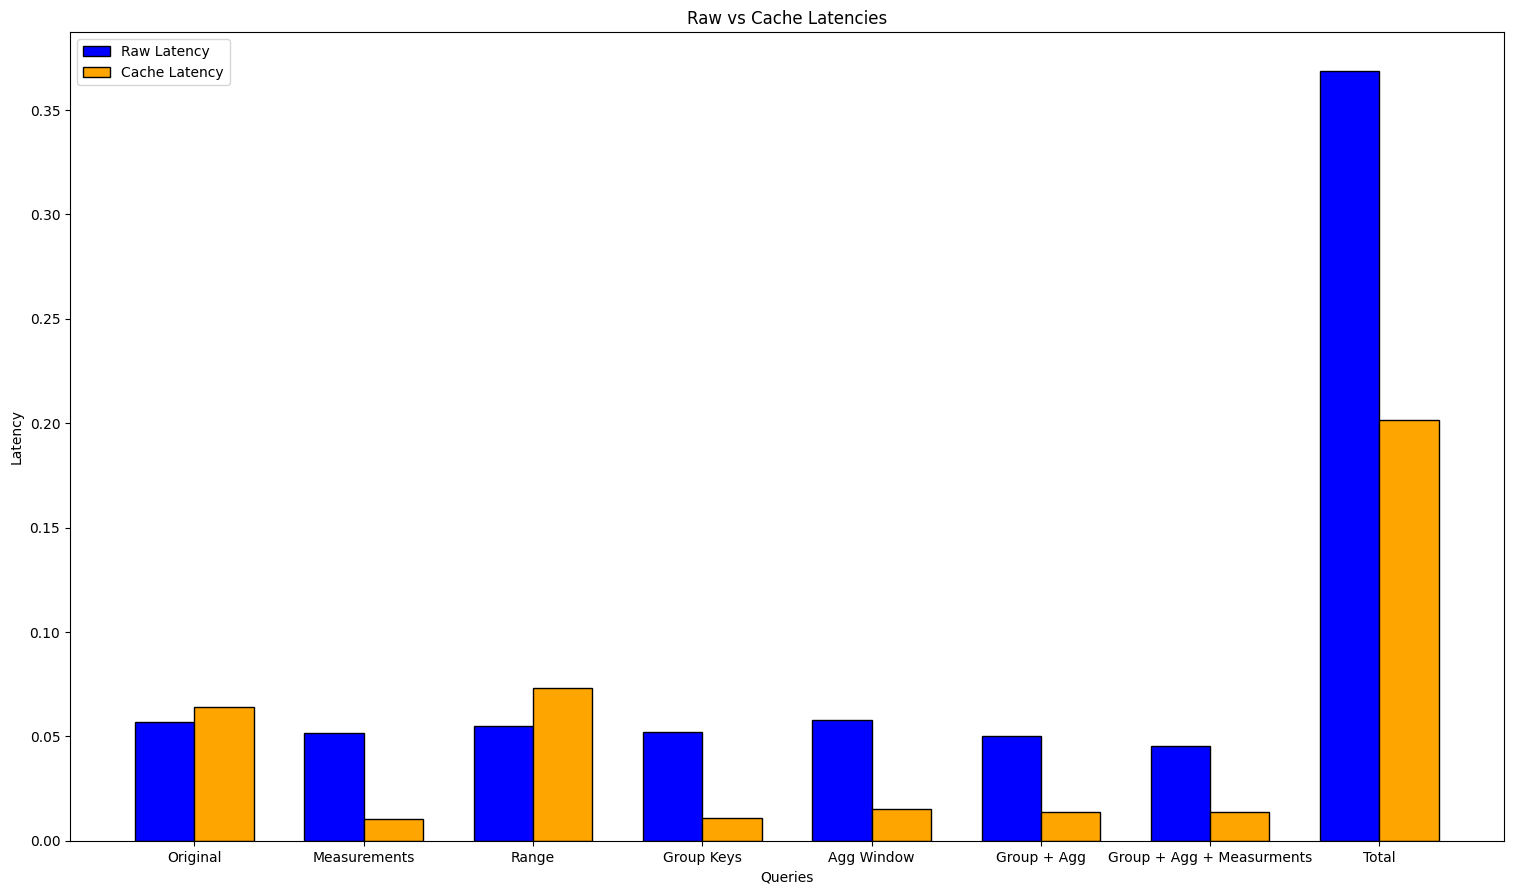

In [91]:
import matplotlib.pyplot as plt

labels = ['Original', 'Measurements', 'Range', 'Group Keys', 'Agg Window', 'Group + Agg', 'Group + Agg + Measurments', 'Total']
all_raw_times = np.append(raw_times, rawLatency)
all_cached_times = np.append(cached_times, cacheLatency)
# Set the width of the bars
bar_width = 0.35

r1 = range(len(all_raw_times))
r2 = [x + bar_width for x in r1]

plt.bar(r1, all_raw_times, color='blue', width=bar_width, edgecolor='black', label='Raw Latency')
plt.bar(r2, all_cached_times, color='orange', width=bar_width, edgecolor='black', label='Cache Latency')

plt.xlabel('Queries')
plt.ylabel('Latency')
plt.title('Raw vs Cache Latencies')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
#Increase figure width
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# Add a legend
plt.legend()

# Show the plot
plt.show()


In [152]:
import importlib
import queryDSL
importlib.reload(queryDSL)
from queryDSL import InfluxQueryBuilder, QueryFilter, QueryAggregation, Range, RelativeRange
from copy import copy


def runRangeLatencyComparison(baseQuery, ranges):
    rawLatencies = []
    cacheLatencies = []
    for newRange in ranges:
        baseQueryCopy = copy(baseQuery)
        modifiedBuilder = baseQueryCopy.withRelativeRange(newRange.fr, newRange.to)
        rawLatency, cacheLatency, rawLatenciesLs, cacheLatenciesLs = runLatencyTest([baseQuery, modifiedBuilder], 30)
        rawLatencies.append(rawLatenciesLs[1])
        cacheLatencies.append(cacheLatenciesLs[1])
    return rawLatencies, cacheLatencies

In [155]:
#reimport builtins
from builtins import range
startingRange = 720
baseInfluxBuilder = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "median", False))
               .withRelativeRange(f'{startingRange}m', None)
               .withGroupKeys(["host", "platform"])
       )

additionalRanges = []
for i in range(6):
    addition = 5 * (2 ** i)
    additionalRanges.append(RelativeRange(f'{startingRange + addition}m', None))
print(additionalRanges)

range_raws, range_cache = runRangeLatencyComparison(baseInfluxBuilder, additionalRanges)
print("Raw Latencies: ", range_raws)
print("Cache Latencies: ", range_cache)

[RelativeRange(fr: 725m, to: None), RelativeRange(fr: 730m, to: None), RelativeRange(fr: 740m, to: None), RelativeRange(fr: 760m, to: None), RelativeRange(fr: 800m, to: None), RelativeRange(fr: 880m, to: None)]
Raw Latencies:  [0.07902016310856261, 0.08323272636958531, 0.0882070779800415, 0.06804615875770306, 0.07180046213084254, 0.07942097527640206]
Cache Latencies:  [0.052641765276590986, 0.06693559487660726, 0.09017924467722575, 0.06427214145660401, 0.060138702392578125, 0.06383113861083985]


In [166]:
def plot_comparison(raws, caches, labels):
    # Set the width of the bars
    bar_width = 0.35

    r1 = range(len(labels))
    r2 = [x + bar_width for x in r1]

    plt.bar(r1, raws, color='blue', width=bar_width, edgecolor='black', label='Raw Latency')
    plt.bar(r2, caches, color='orange', width=bar_width, edgecolor='black', label='Cache Latency')

    plt.xlabel('Queries')
    plt.ylabel('Latency')
    plt.title('Raw vs Cache Latencies with varying query ranges')
    plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
    #Increase figure width
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

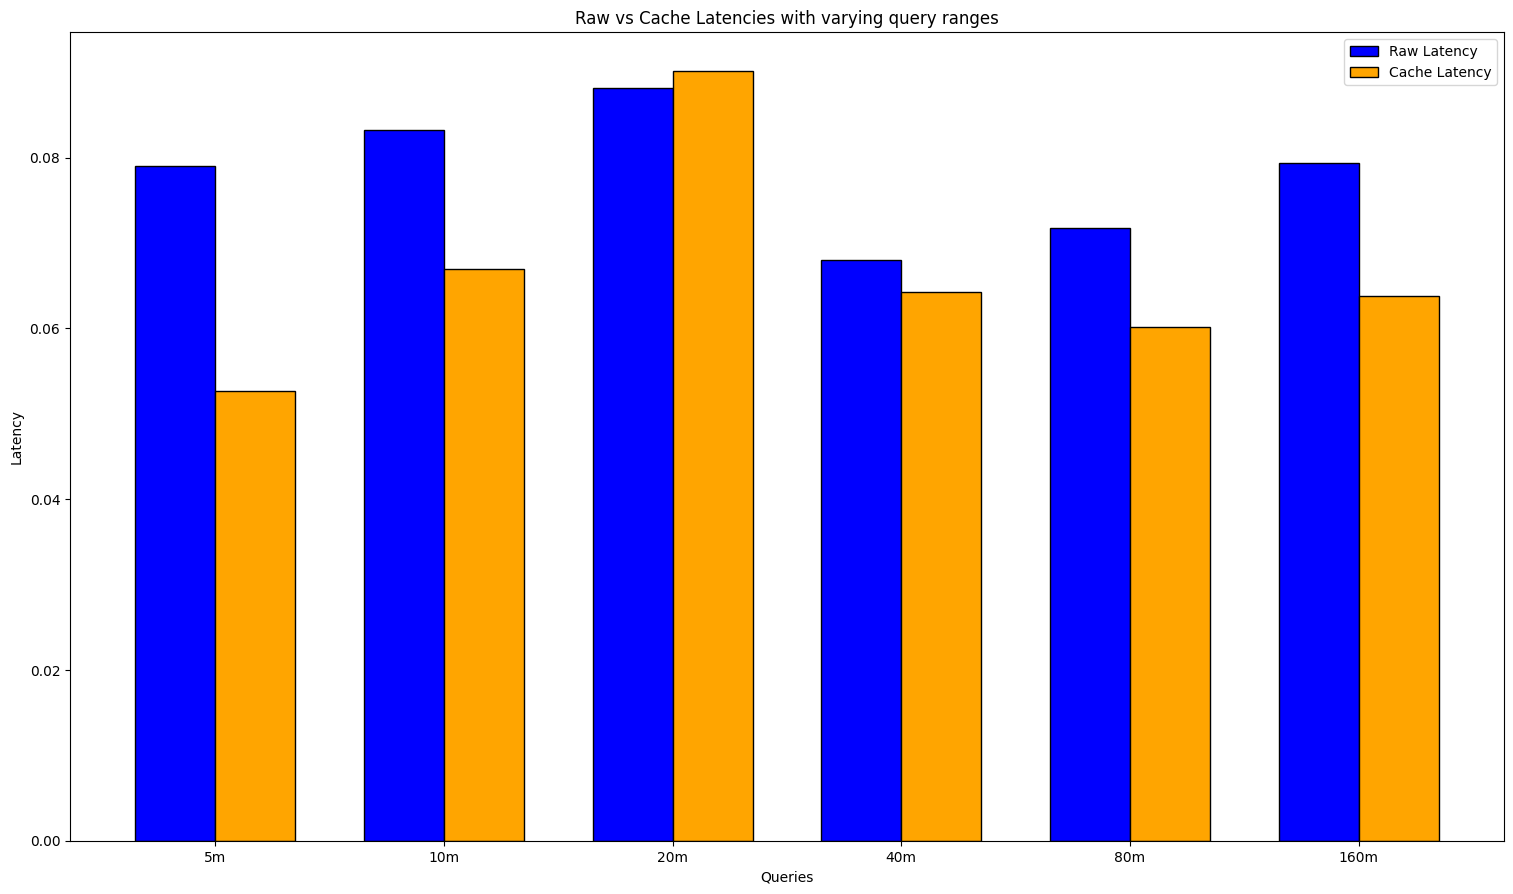

In [157]:
plot_comparison(range_raws, range_cache, additionalRanges)

In [164]:
#Compare efficiency of cache as query size increases
from builtins import range
starting_ranges = [60, 120, 240, 360, 720, 1440]

raw_latencies = []
cache_latencies = []
for starting_range in starting_ranges:
        baseInfluxBuilder = (InfluxQueryBuilder()
                .withBucket("Test")
                .withMeasurements(["cpu_usage", "temperature"])
                .withTable("system_metrics")
                .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
                .withAggregate(QueryAggregation("1m", "median", False))
                .withRelativeRange(f'{starting_range}m', None)
                .withGroupKeys(["host", "platform"])
        )
        additionalRanges = [RelativeRange(f'{starting_range + 10}m', None)]
        print(f"Starting Range: {starting_range}, Additional Range: {additionalRanges}")
        raw_latency, cache_latency = runRangeLatencyComparison(baseInfluxBuilder, additionalRanges)
        raw_latencies.append(raw_latency[0])
        cache_latencies.append(cache_latency[0])

print("Raw Latencies: ", raw_latencies)
print("Cache Latencies: ", cache_latencies)

Starting Range: 60, Additional Range: [RelativeRange(fr: 70m, to: None)]
Starting Range: 120, Additional Range: [RelativeRange(fr: 130m, to: None)]
Starting Range: 240, Additional Range: [RelativeRange(fr: 250m, to: None)]
Starting Range: 360, Additional Range: [RelativeRange(fr: 370m, to: None)]
Starting Range: 720, Additional Range: [RelativeRange(fr: 730m, to: None)]
Starting Range: 1440, Additional Range: [RelativeRange(fr: 1450m, to: None)]
Raw Latencies:  [0.06810044420176539, 0.06682500839233399, 0.06962980895206847, 0.07287464470698915, 0.0668511966179157, 0.11775921953135524]
Cache Latencies:  [0.07053046226501465, 0.09118650754292806, 0.06740461985270182, 0.07276379620587384, 0.06283660729726155, 0.06726612715885558]


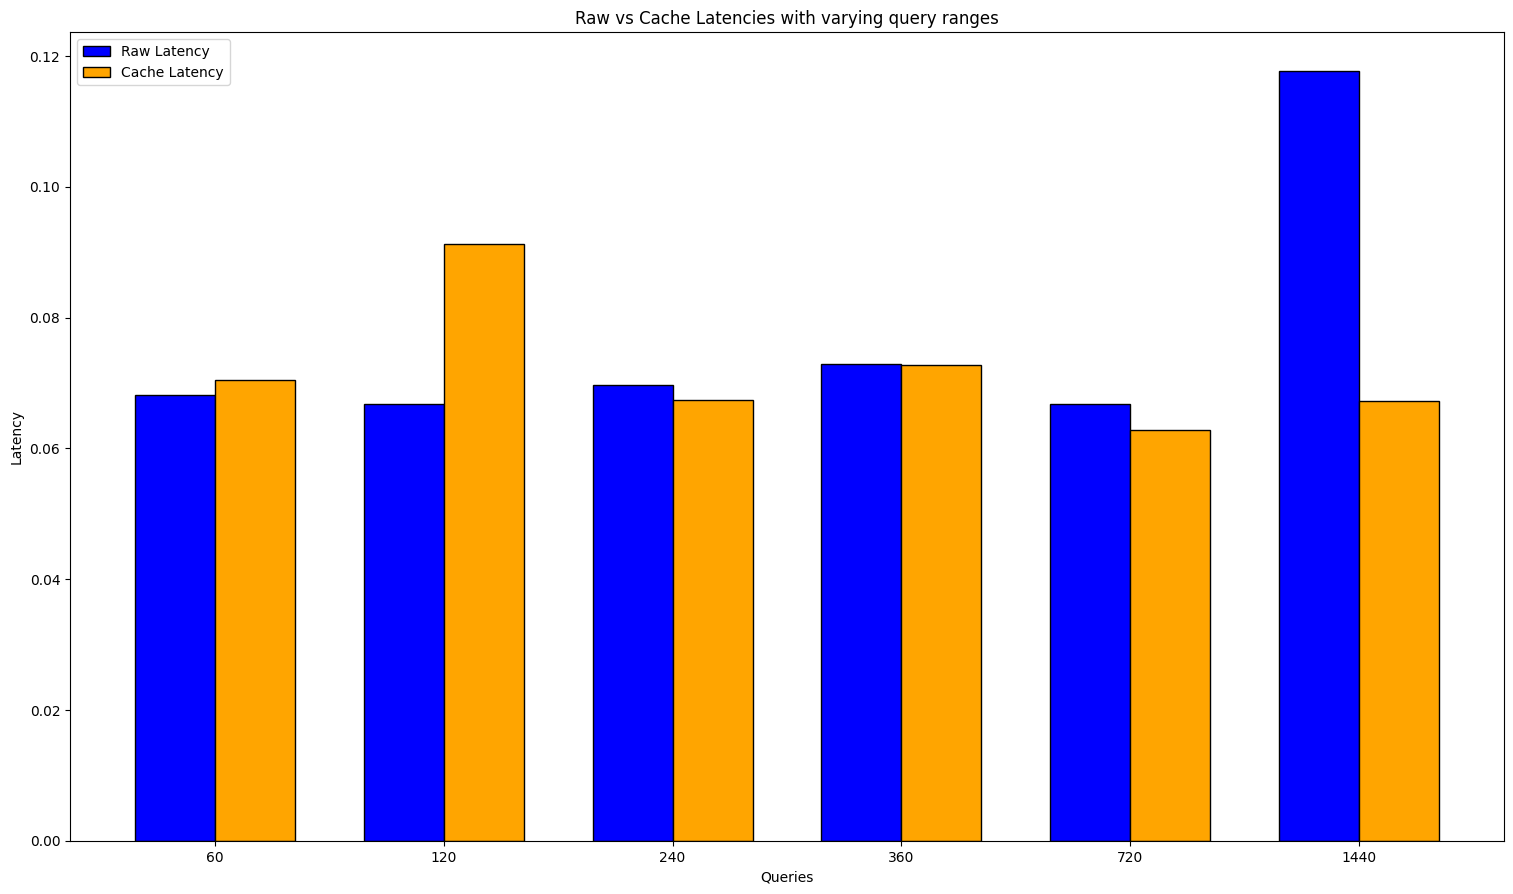

In [167]:
plot_comparison(raw_latencies, cache_latencies, starting_ranges)